In [105]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer

import pickle
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

In [106]:
data = pd.read_csv('./Input/complaints.csv')
data.head()

 24%|██▍       | 193090/809343 [01:52<04:48, 2136.23it/s]

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605
1,2019-11-01,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,088XX,NaN,Consent provided,Web,2019-11-01,Closed with explanation,Yes,NaN,3425257
2,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225
3,2021-11-01,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,31707,NaN,NaN,Web,2021-11-01,In progress,Yes,NaN,4863965
4,2021-11-02,Debt collection,Medical debt,Took or threatened to take negative or legal a...,Threatened or suggested your credit would be d...,NaN,NaN,"Medical Data Systems, Inc.",VA,22033,NaN,NaN,Web,2021-11-02,In progress,Yes,NaN,4866449


In [107]:
data.shape

(2326246, 18)

In [108]:
data['Consumer complaint narrative'][13]

'Receiving daily telephone call ( s ) from XXXX XXXX XXXX identifying themselves as from an attorney \'s office and I am unable to decifer the name after asking 3 times. They ask me to confirm that my name is " prior married name ". I ask what they want and they repeat the question. I responded yes and they hang up. \n\nThe next call from that number was asking me if I was a different name - my maiden name which I recently change to. When I asked for clarification, they hung up. \n\nI have received a total of 6 calls in approx 2 days. They never divulge what they want after attempting to verify my name ( s )'

In [109]:
data['Product'][13]

'Credit reporting, credit repair services, or other personal consumer reports'

In [110]:
data['Consumer complaint narrative'][3401]

"I was looking through my report and noticed a vehicle that I returned to the dealership where it's reporting completely incorrect. I had the opportunity to talk to several lawmakers and friends, and learned some basic laws in regards to voluntary or repossession of a vehicle. Under the laws of MASS and UCC 9.506 as well as State RISA and MVISA statutes, a deficiency can not be claimed unless all of the required notices were properly and timely given, and all of the allowable redemption and cure time limits were adhered to. PLEASE HAVE THEM IMMEDIATELY REMOVE"

In [111]:
data['Product'][3401]

'Vehicle loan or lease'

### Select only 'product' and 'consumer complaint narrative' columns

In [112]:
data = data[['Consumer complaint narrative', 'Product']]

In [113]:
data.head()

,Consumer complaint narrative,Product
0,NaN,"Credit reporting, credit repair services, or o..."
1,I contacted Ally on Friday XX/XX/XXXX after fa...,Vehicle loan or lease
2,NaN,"Credit reporting, credit repair services, or o..."
3,NaN,"Credit reporting, credit repair services, or o..."
4,NaN,Debt collection


In [114]:
data.isna().sum()

Consumer complaint narrative    1516903
Product                               0
dtype: int64

### Drop records with missing complaints

In [115]:
data.dropna(inplace=True)

In [116]:
data.shape

(809343, 2)

In [117]:
data.rename({'Consumer complaint narrative': 'Complaint'}, axis=1, inplace=True)

In [118]:
data.head()

,Complaint,Product
1,I contacted Ally on Friday XX/XX/XXXX after fa...,Vehicle loan or lease
7,Hello This complaint is against the three cred...,"Credit reporting, credit repair services, or o..."
8,I am a victim of Identity Theft & currently ha...,"Credit reporting, credit repair services, or o..."
10,Two accounts are still on my credit history af...,"Credit reporting, credit repair services, or o..."
13,Receiving daily telephone call ( s ) from XXXX...,"Credit reporting, credit repair services, or o..."


### Create unique values for 'product'

In [119]:
data['Product'].unique()

array(['Vehicle loan or lease',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Credit card or prepaid card',
       'Money transfer, virtual currency, or money service', 'Mortgage',
       'Payday loan, title loan, or personal loan', 'Debt collection',
       'Checking or savings account', 'Student loan', 'Consumer Loan',
       'Money transfers', 'Credit card', 'Bank account or service',
       'Credit reporting', 'Prepaid card', 'Payday loan',
       'Other financial service', 'Virtual currency'], dtype=object)

### Create unique values for 'product'

In [120]:
product_map = {
  'Vehicle loan or lease': 'vehicle_loan',
  'Credit reporting, credit repair services, or other personal consumer reports': 'credit_report',
  'Credit card or prepaid card': 'card',
  'Money transfer, virtual currency, or money service': 'money_transfer',
  'virtual currency': 'money_transfer',
  'Mortgage': 'mortgage',
  'Payday loan, title loan, or personal loan': 'loan',
  'Debt collection': 'debt_collection',
  'Checking or savings account': 'savings_account',
  'Credit card': 'card',
  'Bank account or service': 'savings_account',
  'Credit reporting': 'credit_report',
  'Prepaid card': 'card',
  'Payday loan': 'loan',
  'Other financial service': 'others',
  'Virtual currency': 'money_transfer',
  'Student loan': 'loan',
  'Consumer Loan': 'loan',
  'Money transfers': 'money_transfer'
  }

In [121]:
data.replace({'Product': product_map}, inplace=True)

In [122]:
data.head()

,Complaint,Product
1,I contacted Ally on Friday XX/XX/XXXX after fa...,vehicle_loan
7,Hello This complaint is against the three cred...,credit_report
8,I am a victim of Identity Theft & currently ha...,credit_report
10,Two accounts are still on my credit history af...,credit_report
13,Receiving daily telephone call ( s ) from XXXX...,credit_report


### Plot distribution of 'product' column

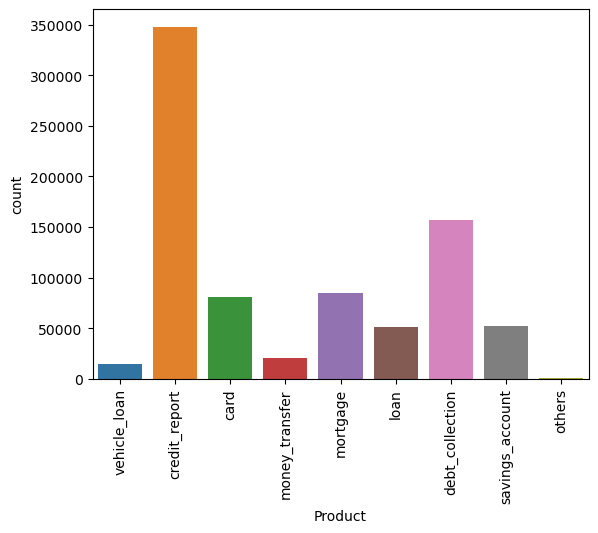

In [123]:
sns.countplot(x='Product', data=data)
plt.xticks(rotation=90)
plt.show()

In [124]:
data['Product'].value_counts()

credit_report      348053
debt_collection    157381
mortgage            84461
card                81042
savings_account     52274
loan                50710
money_transfer      20096
vehicle_loan        15034
others                292
Name: Product, dtype: int64

In [125]:
complaints = list(data['Complaint'])
len(complaints)

809343

### Convert data to lower case

In [126]:
complaints = [c.lower() for c in tqdm(complaints)]

100%|██████████| 809343/809343 [00:00<00:00, 1481645.49it/s]


In [127]:
complaints[13]

'my credit reports list monies owed to xxxx. i have written to the collection agency, xxxx xxxx xxxx requesting proof that i owe monies on this account, but none was ever sent. i notified the credit agencies that this creditor never sent me the required proof, yet they continue to list this account on my credit report. \n\nmy credit reports list xxxx xxxx xxxx and xxxx for monies owed to xxxx. i submitted documentation that showed that the original creditor was paid however, the credit reporting agencies continue to list xxxx xxxx on my credit report. furthermore, two separate collection agencies can not be listed on my creditreport over the same account. \n\nmy credit reports list a bankruptcy that should have been deleted since the 7 years of reporting it has expired.'

In [128]:
complaints[3401]

'xxxx xxxx  sent me a email that it looked like my personal data may had been compromised. i opened it up and reviewed everything and there was several unknown inquiries and accounts that certainly did not belong to me. i pulled my credit to make sure, and these accounts i am reporting are definitely not mine. please remove these items from my report. \n\nbankruptcy chapter xxxx-dismissed xxxx {$0.00}'

### Tokenize text

In [129]:
tokens = [word_tokenize(c) for c in tqdm(complaints)]


100%|██████████| 809343/809343 [08:44<00:00, 1544.47it/s]


In [130]:
tokens[13]

['my',
 'credit',
 'reports',
 'list',
 'monies',
 'owed',
 'to',
 'xxxx',
 '.',
 'i',
 'have',
 'written',
 'to',
 'the',
 'collection',
 'agency',
 ',',
 'xxxx',
 'xxxx',
 'xxxx',
 'requesting',
 'proof',
 'that',
 'i',
 'owe',
 'monies',
 'on',
 'this',
 'account',
 ',',
 'but',
 'none',
 'was',
 'ever',
 'sent',
 '.',
 'i',
 'notified',
 'the',
 'credit',
 'agencies',
 'that',
 'this',
 'creditor',
 'never',
 'sent',
 'me',
 'the',
 'required',
 'proof',
 ',',
 'yet',
 'they',
 'continue',
 'to',
 'list',
 'this',
 'account',
 'on',
 'my',
 'credit',
 'report',
 '.',
 'my',
 'credit',
 'reports',
 'list',
 'xxxx',
 'xxxx',
 'xxxx',
 'and',
 'xxxx',
 'for',
 'monies',
 'owed',
 'to',
 'xxxx',
 '.',
 'i',
 'submitted',
 'documentation',
 'that',
 'showed',
 'that',
 'the',
 'original',
 'creditor',
 'was',
 'paid',
 'however',
 ',',
 'the',
 'credit',
 'reporting',
 'agencies',
 'continue',
 'to',
 'list',
 'xxxx',
 'xxxx',
 'on',
 'my',
 'credit',
 'report',
 '.',
 'furthermore',
 '

In [131]:
tokens[3401]

['xxxx',
 'xxxx',
 'sent',
 'me',
 'a',
 'email',
 'that',
 'it',
 'looked',
 'like',
 'my',
 'personal',
 'data',
 'may',
 'had',
 'been',
 'compromised',
 '.',
 'i',
 'opened',
 'it',
 'up',
 'and',
 'reviewed',
 'everything',
 'and',
 'there',
 'was',
 'several',
 'unknown',
 'inquiries',
 'and',
 'accounts',
 'that',
 'certainly',
 'did',
 'not',
 'belong',
 'to',
 'me',
 '.',
 'i',
 'pulled',
 'my',
 'credit',
 'to',
 'make',
 'sure',
 ',',
 'and',
 'these',
 'accounts',
 'i',
 'am',
 'reporting',
 'are',
 'definitely',
 'not',
 'mine',
 '.',
 'please',
 'remove',
 'these',
 'items',
 'from',
 'my',
 'report',
 '.',
 'bankruptcy',
 'chapter',
 'xxxx-dismissed',
 'xxxx',
 '{',
 '$',
 '0.00',
 '}']

### Remove stop words

In [132]:
sw = stopwords.words('english')

In [133]:
sw[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [134]:
tokens = [[word for word in t if word not in sw] for t in tqdm(tokens)]

100%|██████████| 809343/809343 [04:27<00:00, 3029.59it/s]


### Remove punctuation marks

In [135]:
tokenizer = RegexpTokenizer(r'\w+')

In [136]:
tokens = [["".join(tokenizer.tokenize(word)) for word in t
          if len(tokenizer.tokenize(word)) > 0] for t in tqdm(tokens)]

100%|██████████| 809343/809343 [02:51<00:00, 4732.52it/s]


In [137]:
tokens[13]

['credit',
 'reports',
 'list',
 'monies',
 'owed',
 'xxxx',
 'written',
 'collection',
 'agency',
 'xxxx',
 'xxxx',
 'xxxx',
 'requesting',
 'proof',
 'owe',
 'monies',
 'account',
 'none',
 'ever',
 'sent',
 'notified',
 'credit',
 'agencies',
 'creditor',
 'never',
 'sent',
 'required',
 'proof',
 'yet',
 'continue',
 'list',
 'account',
 'credit',
 'report',
 'credit',
 'reports',
 'list',
 'xxxx',
 'xxxx',
 'xxxx',
 'xxxx',
 'monies',
 'owed',
 'xxxx',
 'submitted',
 'documentation',
 'showed',
 'original',
 'creditor',
 'paid',
 'however',
 'credit',
 'reporting',
 'agencies',
 'continue',
 'list',
 'xxxx',
 'xxxx',
 'credit',
 'report',
 'furthermore',
 'two',
 'separate',
 'collection',
 'agencies',
 'listed',
 'creditreport',
 'account',
 'credit',
 'reports',
 'list',
 'bankruptcy',
 'deleted',
 'since',
 '7',
 'years',
 'reporting',
 'expired']

In [138]:
tokens[3401]

['xxxx',
 'xxxx',
 'sent',
 'email',
 'looked',
 'like',
 'personal',
 'data',
 'may',
 'compromised',
 'opened',
 'reviewed',
 'everything',
 'several',
 'unknown',
 'inquiries',
 'accounts',
 'certainly',
 'belong',
 'pulled',
 'credit',
 'make',
 'sure',
 'accounts',
 'reporting',
 'definitely',
 'mine',
 'please',
 'remove',
 'items',
 'report',
 'bankruptcy',
 'chapter',
 'xxxxdismissed',
 'xxxx',
 '000']

#### Remove 'xxxx' and '0000' tokens

In [139]:
tokens = [[t for t in token if t not in ['xxxx', '000']] for token in tqdm(tokens)]

100%|██████████| 809343/809343 [01:11<00:00, 11301.27it/s]


In [140]:
tokens[13]

['credit',
 'reports',
 'list',
 'monies',
 'owed',
 'written',
 'collection',
 'agency',
 'requesting',
 'proof',
 'owe',
 'monies',
 'account',
 'none',
 'ever',
 'sent',
 'notified',
 'credit',
 'agencies',
 'creditor',
 'never',
 'sent',
 'required',
 'proof',
 'yet',
 'continue',
 'list',
 'account',
 'credit',
 'report',
 'credit',
 'reports',
 'list',
 'monies',
 'owed',
 'submitted',
 'documentation',
 'showed',
 'original',
 'creditor',
 'paid',
 'however',
 'credit',
 'reporting',
 'agencies',
 'continue',
 'list',
 'credit',
 'report',
 'furthermore',
 'two',
 'separate',
 'collection',
 'agencies',
 'listed',
 'creditreport',
 'account',
 'credit',
 'reports',
 'list',
 'bankruptcy',
 'deleted',
 'since',
 '7',
 'years',
 'reporting',
 'expired']

In [141]:
tokens[3401]

['sent',
 'email',
 'looked',
 'like',
 'personal',
 'data',
 'may',
 'compromised',
 'opened',
 'reviewed',
 'everything',
 'several',
 'unknown',
 'inquiries',
 'accounts',
 'certainly',
 'belong',
 'pulled',
 'credit',
 'make',
 'sure',
 'accounts',
 'reporting',
 'definitely',
 'mine',
 'please',
 'remove',
 'items',
 'report',
 'bankruptcy',
 'chapter',
 'xxxxdismissed']

#### Check word count for couple of classes

In [142]:
data['clean_complaints'] = tokens

In [143]:
data.head()

,Complaint,Product,clean_complaints
1,I contacted Ally on Friday XX/XX/XXXX after fa...,vehicle_loan,"[contacted, ally, friday, xxxxxxxx, falling, b..."
7,Hello This complaint is against the three cred...,credit_report,"[hello, complaint, three, credit, reporting, c..."
8,I am a victim of Identity Theft & currently ha...,credit_report,"[victim, identity, theft, currently, experian,..."
10,Two accounts are still on my credit history af...,credit_report,"[two, accounts, still, credit, history, contac..."
13,Receiving daily telephone call ( s ) from XXXX...,credit_report,"[receiving, daily, telephone, call, identifyin..."


In [144]:
loan_complaints = list(data[data['Product'] == 'loan']['clean_complaints'])


In [145]:
loan_complaints = [token for complaint in tqdm(loan_complaints) for token in complaint]

100%|██████████| 50710/50710 [00:02<00:00, 23520.74it/s]


In [146]:
counter = Counter(loan_complaints)
counter.most_common(10)

[('loan', 108721),
 ('payment', 69612),
 ('xxxxxxxx', 54859),
 ('payments', 54658),
 ('would', 51778),
 ('loans', 49381),
 ('account', 44823),
 ('credit', 40709),
 ('told', 38378),
 ('pay', 36730)]

In [147]:
card_complaints = list(data[data['Product'] == 'card']['clean_complaints'])

In [148]:
card_complaints = [token for complaint in tqdm(card_complaints) for token in complaint]

100%|██████████| 81042/81042 [00:02<00:00, 29725.81it/s]


In [149]:
counter = Counter(card_complaints)
counter.most_common(10)

[('card', 188911),
 ('credit', 180949),
 ('account', 143171),
 ('xxxxxxxx', 95253),
 ('would', 74332),
 ('bank', 68126),
 ('payment', 68015),
 ('told', 57508),
 ('called', 53979),
 ('one', 53750)]

In [150]:
counter = Counter([t for complaint in tqdm(tokens) for t in complaint])

100%|██████████| 809343/809343 [00:08<00:00, 95409.54it/s] 


In [151]:
counter.most_common(10)

[('credit', 1371264),
 ('account', 1098988),
 ('xxxxxxxx', 889650),
 ('report', 632326),
 ('information', 584507),
 ('would', 478585),
 ('payment', 472922),
 ('loan', 425411),
 ('debt', 413992),
 ('bank', 379931)]

In [152]:
# find total unique tokens
len(counter.keys())

243338

In [153]:
clean_complaints = [" ".join(complaint) for complaint in tqdm(tokens)]

100%|██████████| 809343/809343 [00:06<00:00, 120233.82it/s]


In [154]:
clean_complaints[13]

'credit reports list monies owed written collection agency requesting proof owe monies account none ever sent notified credit agencies creditor never sent required proof yet continue list account credit report credit reports list monies owed submitted documentation showed original creditor paid however credit reporting agencies continue list credit report furthermore two separate collection agencies listed creditreport account credit reports list bankruptcy deleted since 7 years reporting expired'

In [155]:
clean_complaints[3401]

'sent email looked like personal data may compromised opened reviewed everything several unknown inquiries accounts certainly belong pulled credit make sure accounts reporting definitely mine please remove items report bankruptcy chapter xxxxdismissed'

## Data Preparation

### Vectorize the data

In [156]:
vect = CountVectorizer(min_df=200)

In [157]:
X = vect.fit_transform(clean_complaints)

In [158]:
X.shape

(809343, 8547)

In [159]:
y = data['Product']

#### Split the data into train and test

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y ,random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(647474, 8547) (647474,) (161869, 8547) (161869,)


## Model Training

### Crate a multinomial Naive Bayes model

In [161]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

### Predict on the test set

In [162]:
test_predict = model.predict(X_test)
print('accuracy_score: ', accuracy_score(y_test, test_predict))

accuracy_score:  0.787371269359791


### Visualize confusion matrix

In [163]:
conf_mat = confusion_matrix(y_test, test_predict)
print(conf_mat)

[[12285  1137   422   358   522    63    16  1254   152]
 [ 3126 56518  4646  1578   240  1071    61   410  1961]
 [ 1091  4539 22698  1481   131   555    30   332   619]
 [  296   519   633  6966    91   246    17   229  1145]
 [  154    18    29    27  3207    36    25   516     7]
 [  164   354   198   364    65 15383    16   235   113]
 [    3     0     4    19     4     4     7    17     0]
 [  777   182    93    73   877   159    18  8217    59]
 [   70   261   115   295     4    41     3    48  2170]]


In [164]:
conf_mat = pd.DataFrame(conf_mat, columns=model.classes_, index=model.classes_)
conf_mat

,card,credit_report,debt_collection,loan,money_transfer,mortgage,others,savings_account,vehicle_loan
card,12285,1137,422,358,522,63,16,1254,152
credit_report,3126,56518,4646,1578,240,1071,61,410,1961
debt_collection,1091,4539,22698,1481,131,555,30,332,619
loan,296,519,633,6966,91,246,17,229,1145
money_transfer,154,18,29,27,3207,36,25,516,7
mortgage,164,354,198,364,65,15383,16,235,113
others,3,0,4,19,4,4,7,17,0
savings_account,777,182,93,73,877,159,18,8217,59
vehicle_loan,70,261,115,295,4,41,3,48,2170


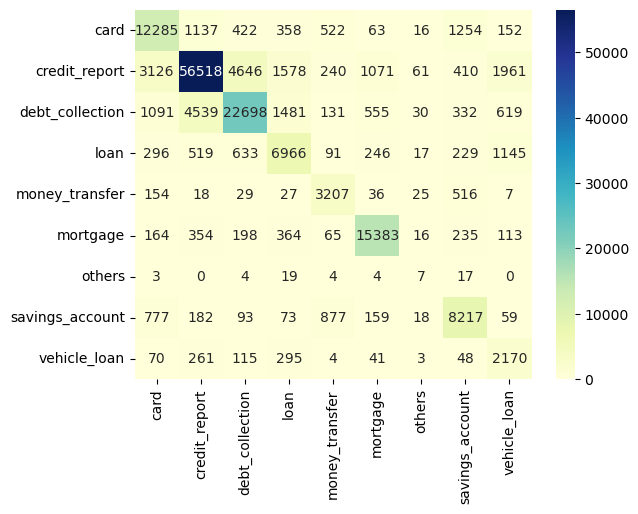

In [188]:
sns.heatmap(data=conf_mat, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

#### Save vectorizer and model object

In [167]:
with open('Output/count_vect.pkl', 'wb') as f:
    pickle.dump(vect, f)
with open('Output/nb.pkl', 'wb') as f:
    pickle.dump(model, f)

## Prediction

In [168]:
data['Complaint'][1545]

'I have a debt of Bank of America which was written off by the bank XX/XX/XXXX without my knowledge. I went to the bank XXXX XXXX since a law group kept on delving on XXXX XXXX Clerk File and garnishing salary from my work.This case has been closed.I paid a lesser amount to the bank to close this debt XXXX I sent them checks. I will greatly appreciate if this case will be resolve.'

In [169]:
data['Product'][1545]

'debt_collection'

In [171]:
data['Complaint'][5001]

'This is a personal Delta American Express charge card. I am a 30 year customer with American Express. I suddenly, without notice or warning have noted that " Charging Privileges Have Been Suspended \'\'. The card is current, with no money owed. This notice is only available online and I never received ANY written advice of this action. My account is not " paperless \'\'. At the phone number provided to call for information, after nearly an hour on the phone THREE TIMES, no explanation was ever provided and I was advised I " would be contacted \'\' to explain the ( lack of ) issue. I was never contacted. I had accumulated miles points on the card that I can not access and my charge privileges have been suspended. I am unable to obtain any information.'

In [172]:
data['Product'][5001]

'card'

In [173]:
test_complaint_1 = data['Complaint'][1545]
test_complaint_2 = data['Complaint'][5001]

In [174]:
test_complaint = [test_complaint_1, test_complaint_2]

### Load the vectorizer and model objects

In [175]:
vect = pickle.load(open('Output/count_vect.pkl', 'rb'))
model = pickle.load(open('Output/nb.pkl', 'rb'))

### Process test data

In [176]:
test_complaints = [r.lower() for r in test_complaint]

In [177]:
test_complaints

['i have a debt of bank of america which was written off by the bank xx/xx/xxxx without my knowledge. i went to the bank xxxx xxxx since a law group kept on delving on xxxx xxxx clerk file and garnishing salary from my work.this case has been closed.i paid a lesser amount to the bank to close this debt xxxx i sent them checks. i will greatly appreciate if this case will be resolve.',
 'this is a personal delta american express charge card. i am a 30 year customer with american express. i suddenly, without notice or warning have noted that " charging privileges have been suspended \'\'. the card is current, with no money owed. this notice is only available online and i never received any written advice of this action. my account is not " paperless \'\'. at the phone number provided to call for information, after nearly an hour on the phone three times, no explanation was ever provided and i was advised i " would be contacted \'\' to explain the ( lack of ) issue. i was never contacted. 

In [178]:
test_tokens = [word_tokenize(r) for r in test_complaint]

In [179]:
test_tokens = [[word for word in t if word not in sw] for t in test_tokens]

In [182]:
test_tokens = [["".join(tokenizer.tokenize(word)) for word in t
               if len(tokenizer.tokenize(word)) > 0] for t in test_tokens]

In [184]:
test_tokens = [[t for t in token if t not in ['xxxx', '000']] for token in test_tokens]

In [185]:
clean_test_complaints = [" ".join(complaint) for complaint in test_tokens]

### Vectorize test data

In [186]:
X_test = vect.transform(clean_test_complaints)

### Make predictions

In [187]:
model.predict(X_test)

array(['debt_collection', 'card'], dtype='<U15')